___
# Report classification using BoW
___

In [1]:
import numpy as np
import pandas as pd
import utils
from time import time

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.pipeline import make_pipeline

from sklearn.metrics import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vrozova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


___
# Data preparation

In [2]:
# Load the development set
df = pd.read_csv("../datasets/reports_dev.csv")

# Clean text
df['clean_text'] = df.report_text.apply(utils.clean_text)

# Define features and labels
X = df.clean_text 
y = df.y
groups = df.patient_id

___
# Model selection
### Quick&dirty trying a few algorithms

In [3]:
vectorizer = TfidfVectorizer(min_df=2, stop_words=stopwords.words('english'))

clfs = (
    SVC(probability=True),
    LogisticRegression(solver='lbfgs', max_iter=1000, class_weight="balanced", random_state=42),
    MultinomialNB(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(class_weight="balanced", random_state=42),
    RandomForestClassifier(class_weight="balanced", random_state=42),
    GradientBoostingClassifier(random_state=42),
)

for clf in clfs:
    pipe = make_pipeline(vectorizer, clf)
    utils.score_cv(pipe, X, y, groups)

________________________________________________________________________________
Training with 10-fold cross-validation:
SVC(probability=True)
train time: 1.386s
ROC AUC score: 0.962 (+/- 0.04)
AP score: 0.861 (+/- 0.14)

________________________________________________________________________________
Training with 10-fold cross-validation:
LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
train time: 0.105s
ROC AUC score: 0.965 (+/- 0.04)
AP score: 0.901 (+/- 0.11)

________________________________________________________________________________
Training with 10-fold cross-validation:
MultinomialNB()
train time: 0.097s
ROC AUC score: 0.905 (+/- 0.11)
AP score: 0.834 (+/- 0.18)

________________________________________________________________________________
Training with 10-fold cross-validation:
KNeighborsClassifier()
train time: 0.104s
ROC AUC score: 0.919 (+/- 0.07)
AP score: 0.674 (+/- 0.25)

_______________________________________________________________

### Proper model comparison with nested CV 

In [4]:
clfs = []
search_modes = []
param_grids = []

# SVC
clfs.append(SVC(probability=True))
search_modes.append('grid')

c = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.5, 1, 10, 15, 20, 25, 30, 50]
param_grid = {"svc__C": c}
param_grids.append(param_grid)

# Logreg
clfs.append(LogisticRegression(solver='lbfgs', max_iter=1000, class_weight="balanced", random_state=42))
search_modes.append('grid')

c = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.5, 1, 10, 15, 20, 25, 30, 50]
param_grid = {"logisticregression__C": c}
param_grids.append(param_grid)

# MNB
clfs.append(MultinomialNB())
search_modes.append('grid')

alpha = [0, 1e-2, 1e-1, 0.25, 0.5, 1, 10, 15, 20, 25, 30, 50]
param_grid = {"multinomialnb__alpha": alpha}
param_grids.append(param_grid)

# GB
clfs.append(GradientBoostingClassifier(random_state=42))
search_modes.append('random')

n_estimators = [100, 200, 300, 400]
max_depth = [2, 4, 6, 8]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4]
subsample = [0.3, 0.5, 0.8, 1.0]
param_grid = {
    "gradientboostingclassifier__n_estimators": n_estimators,
    "gradientboostingclassifier__max_depth": max_depth, 
    "gradientboostingclassifier__learning_rate": learning_rate, 
    "gradientboostingclassifier__subsample": subsample
}
param_grids.append(param_grid)

In [5]:
vectorizer = TfidfVectorizer(min_df=2, stop_words=stopwords.words('english'))

for clf, search_mode, param_grid in zip(clfs, search_modes, param_grids):
    
    pipe = make_pipeline(vectorizer, clf)
    utils.benchmark_nestedcv(pipe, search_mode, param_grid, X, y, groups)

________________________________________________________________________________
Evaluating with outer 10-fold cross-validation and tuning hyperparameters with inner 3-fold cross-validation:
SVC(probability=True)
Best for current fold: 0.861 using {'svc__C': 10}
Best for current fold: 0.681 using {'svc__C': 10}
Best for current fold: 0.815 using {'svc__C': 0.25}
Best for current fold: 0.854 using {'svc__C': 10}
Best for current fold: 0.779 using {'svc__C': 10}
Best for current fold: 0.785 using {'svc__C': 10}
Best for current fold: 0.918 using {'svc__C': 10}
Best for current fold: 0.811 using {'svc__C': 10}
Best for current fold: 0.868 using {'svc__C': 10}
Best for current fold: 0.766 using {'svc__C': 10}
train time: 6.406s
ROC AUC score: 0.974 (+/- 0.04)
AP score: 0.930 (+/- 0.10)
________________________________________________________________________________
Evaluating with outer 10-fold cross-validation and tuning hyperparameters with inner 3-fold cross-validation:
LogisticRegressi

### Tune the final model

In [6]:
vectorizer = TfidfVectorizer(min_df=2, stop_words=stopwords.words('english'))
clf = GradientBoostingClassifier(random_state=42)
pipe = make_pipeline(vectorizer, clf)

n_estimators = [100, 200, 300, 400]
param_grid = {"gradientboostingclassifier__n_estimators": n_estimators}

best_params = utils.search_params(pipe, 'grid', param_grid, X, y, groups)
pipe.set_params(**best_params)

Best for current fold: 0.935 using {'gradientboostingclassifier__n_estimators': 100}
0.935 (+/- 0.103) with: {'gradientboostingclassifier__n_estimators': 100}
0.935 (+/- 0.103) with: {'gradientboostingclassifier__n_estimators': 200}
0.934 (+/- 0.104) with: {'gradientboostingclassifier__n_estimators': 300}
0.934 (+/- 0.104) with: {'gradientboostingclassifier__n_estimators': 400}



Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=2,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=42))])

In [7]:
max_depth = [2, 4, 6, 8]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4]
subsample = [0.3, 0.5, 0.8, 1.0]

param_grid = {"gradientboostingclassifier__max_depth": max_depth, 
              "gradientboostingclassifier__learning_rate": learning_rate, 
              "gradientboostingclassifier__subsample": subsample
             }

best_params = utils.search_params(pipe, 'random', param_grid, X, y, groups, refit=False, verbose=True)
best_model = pipe.set_params(**best_params)

Best for current fold: 0.997 using {'gradientboostingclassifier__subsample': 0.3, 'gradientboostingclassifier__max_depth': 2, 'gradientboostingclassifier__learning_rate': 0.1}
0.979 (+/- 0.047) with: {'gradientboostingclassifier__subsample': 0.3, 'gradientboostingclassifier__max_depth': 2, 'gradientboostingclassifier__learning_rate': 0.01}
0.960 (+/- 0.071) with: {'gradientboostingclassifier__subsample': 0.8, 'gradientboostingclassifier__max_depth': 2, 'gradientboostingclassifier__learning_rate': 0.4}
0.920 (+/- 0.120) with: {'gradientboostingclassifier__subsample': 1.0, 'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__learning_rate': 0.4}
0.865 (+/- 0.177) with: {'gradientboostingclassifier__subsample': 1.0, 'gradientboostingclassifier__max_depth': 8, 'gradientboostingclassifier__learning_rate': 0.001}
0.913 (+/- 0.126) with: {'gradientboostingclassifier__subsample': 1.0, 'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__learning_rate': 0

___
# Model evaluation
### Evaluate the final model using CV

________________________________________________________________________________
Training with 10-fold cross-validation:
GradientBoostingClassifier(max_depth=2, random_state=42, subsample=0.3)
train time: 0.335s
ROC AUC score: 0.999 (+/- 0.00)
AP score: 0.997 (+/- 0.01)

The threshold optimises F1-score calculated from the PR curve.
Best threshold for the model = 0.650, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold for the model = 0.196, F1-score = 0.923

The threshold optimises F1-score calculated from the PR curve.
Best threshold for the model = 0.010, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold for the model = 0.795, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold for the model = 0.971, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold for the model = 0.830, F1-score = 1.000

The threshold 

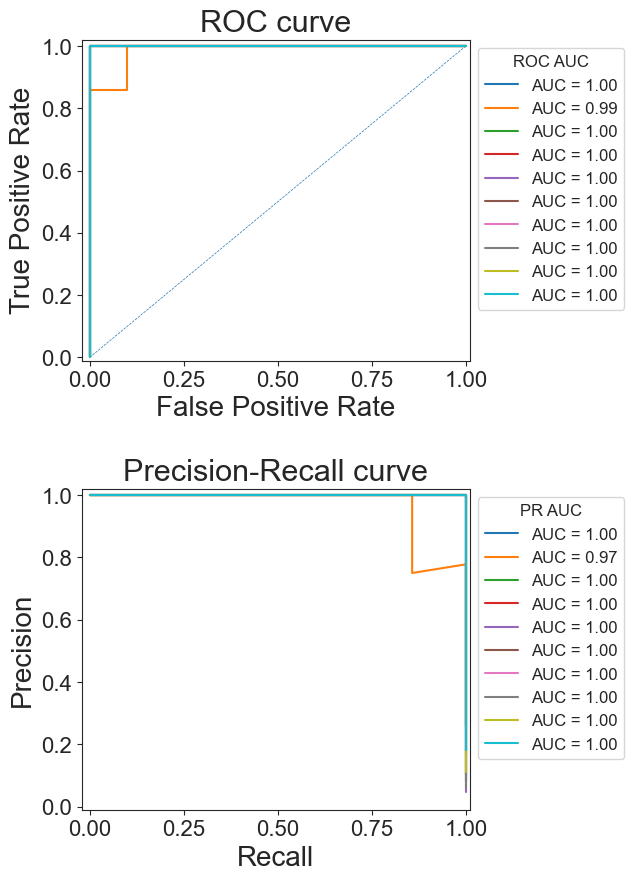

In [8]:
# Model performance in each CV fold
utils.score_cv(best_model, X, y, groups)

# Make predictions for each CV fold
y_proba = utils.predict_cv(best_model, X, y, groups, options=['plot_curves', 'select_threshold'])

The threshold optimises F1-score calculated from the PR curve.
Best threshold for the model = 0.196, F1-score = 0.900

Proportion of labels predicted as positive: 12.2%
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       198
           1       0.96      0.84      0.90        32

    accuracy                           0.97       230
   macro avg       0.97      0.92      0.94       230
weighted avg       0.97      0.97      0.97       230

PPV: 0.96, Sensitivity: 0.84, Specificity: 0.99


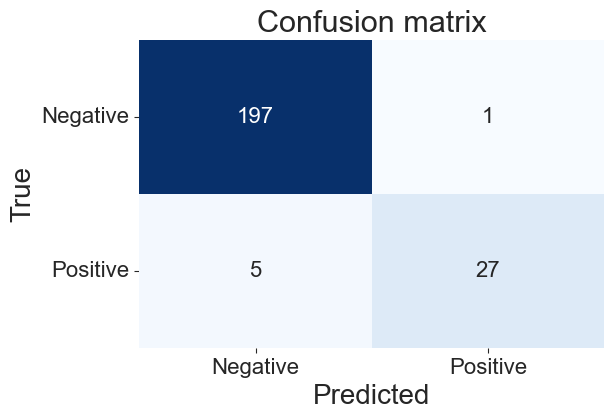

In [9]:
# Find the optimal threshold using aggregated predictions
thresh = utils.select_threshold(y, y_proba)

# Evaluate classification using aggregated predictions
y_pred = utils.evaluate_classification(y, y_proba, thresh, filename="bow_cv")

### Train the final model on the full development set

In [10]:
# Re-train the final model on the full training set
best_model.fit(X, y)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=2,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=2, random_state=42,
                                            subsample=0.3))])

In [11]:
best_model[0].get_feature_names_out().shape

(1726,)

### Test the final model on test data

In [12]:
# Load the test set
df_test = pd.read_csv("../datasets/reports_test.csv")

# Clean text
df_test['clean_text'] = df_test.report_text.apply(utils.clean_text)

# Define test set features and labels
X_test = df_test.clean_text 
y_test = df_test.y

# Make predictions
y_proba = best_model.predict_proba(X_test)
y_proba = y_proba[:,1]

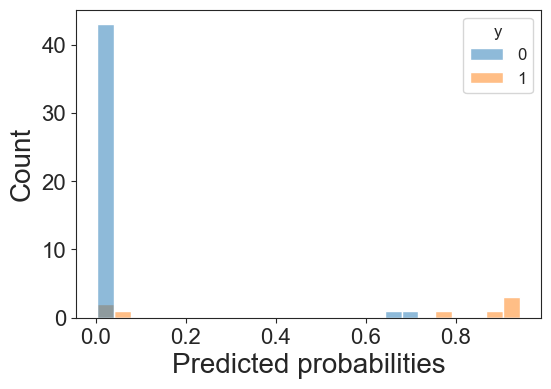

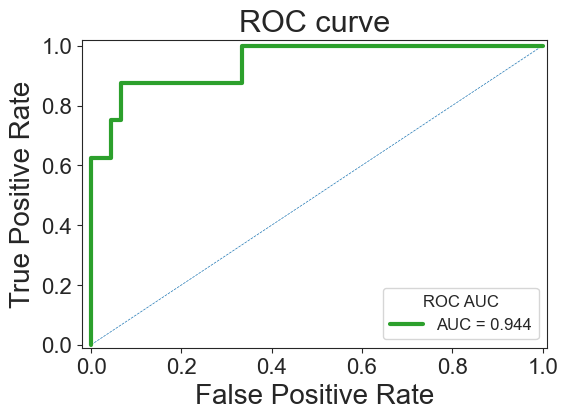

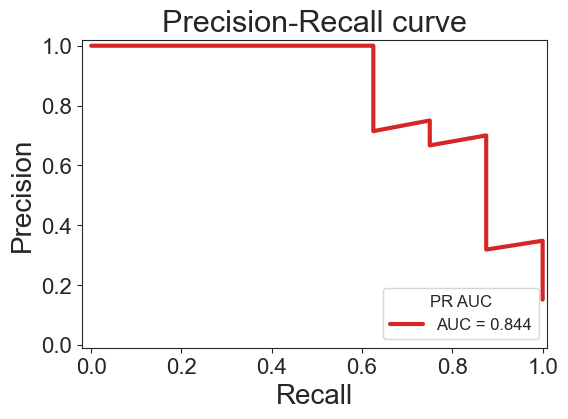

In [13]:
# Plot curves
utils.plot_curves(y_test, y_proba, filename="bow_test")

Proportion of labels predicted as positive: 13.2%
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95        45
           1       0.71      0.62      0.67         8

    accuracy                           0.91        53
   macro avg       0.82      0.79      0.81        53
weighted avg       0.90      0.91      0.90        53

PPV: 0.71, Sensitivity: 0.62, Specificity: 0.96


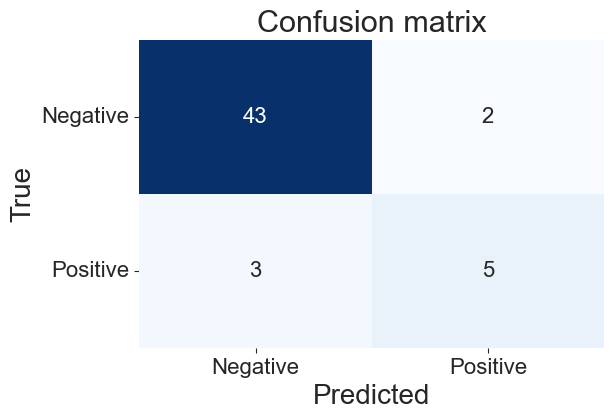

In [14]:
# Evaluate classification
_ = utils.evaluate_classification(y_test, y_proba, thresh, filename="bow_test")